In [1]:
# import all libraries
import pandas as pd
import joblib
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
import matplotlib as plt
from xgboost import plot_importance
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

In [2]:
# Path settings


path_var = 1 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/Option_Pricing/datasets/'
    mdoelpath = '/home/sharan/Desktop/Option_Pricing/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 3                     #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    n_feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
    b_feats = pd.read_csv(bnfty_ecdf)
    
else:
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(bnfty)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################

n_feats = n_feats.drop(dropNames, axis = 1)
b_feats = b_feats.drop(dropNames, axis = 1)

feats = n_feats.append(b_feats, ignore_index=True)

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']    

Approach var set to :: 3


In [4]:

featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)


In [5]:
# # Save the scalar file

joblib.dump(scaler, modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')
print("Scaler saved to path ::", modelpath + 'SCALER_NF+BNF_Expt' + str(approach) + '.model')

Scaler saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/SCALER_NF+BNF_Expt3.model


In [6]:
# Split the train and test sets without random optimizations


a = len(n_feats)
split_val = round(a*0.8)

# Removing the Random splits

Ntrain = n_feats.iloc[0:split_val, :]
Ntest = n_feats.iloc[split_val:, :]

b = len(b_feats)
split_val = round(b*0.8)

# Removing the Random splits

Btrain = b_feats.iloc[0:split_val, :]
Btest = b_feats.iloc[split_val:, :]


train = Ntrain.append(Btrain, ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

test = Ntest.append(Btest, ignore_index=True)

test = test.sample(frac=1).reset_index(drop=True)

X_train=train.iloc[:,:-1]
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = featNames)
Y_train=train.loc[:,'Target']
Y_train = Y_train.values
Y_train = Y_train.reshape(len(Y_train), 1)

X_test=test.iloc[:,:-1]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = featNames)
Y_test=test.loc[:,'Target']
Y_test = Y_test.values
Y_test = Y_test.reshape(len(Y_test), 1)

print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

X & Y_Dim of Train is (27144, 19) (27144, 1)
X & Y_Dim of Test is (6786, 19) (6786, 1)


In [7]:
# param = 
model = XGBClassifier(n_estimators = 250, max_depth = 4, learning_rate = 0.25, n_jobs=4)
%time model.fit(X_train, Y_train)
print(model)


/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/docboy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 10min 57s, sys: 2.38 s, total: 10min 59s
Wall time: 3min 4s
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [8]:
k = model.predict(X_test)

In [9]:
# Normalized Error Metric (NEM)

bin_width = 0.1    # Note the uniform binning!!!!!!!!
dist_sum = 0
for i in range(len(k)):
    dist = abs(k[i] - Y_test[i])
    dist_sum = dist_sum + dist
    
print("NEM :: ", (dist_sum*bin_width)/len(Y_test))

NEM ::  [0.15750074]


In [10]:
accuracy_score(Y_test, k)*100
# print(classification_report(Y_test, k))

28.514588859416445

In [17]:
# Saving the model
joblib.dump(model, modelpath + 'NF+BNF_Expt_NEW' + str(approach) + '.model')
print("Model saved to path ::", modelpath + 'NF+BNF_Expt_NEW' + str(approach) + '.model' )

Model saved to path :: /home/docboy/Desktop/Option_Pricing/pickles/NF+BNF_Expt_NEW3.model


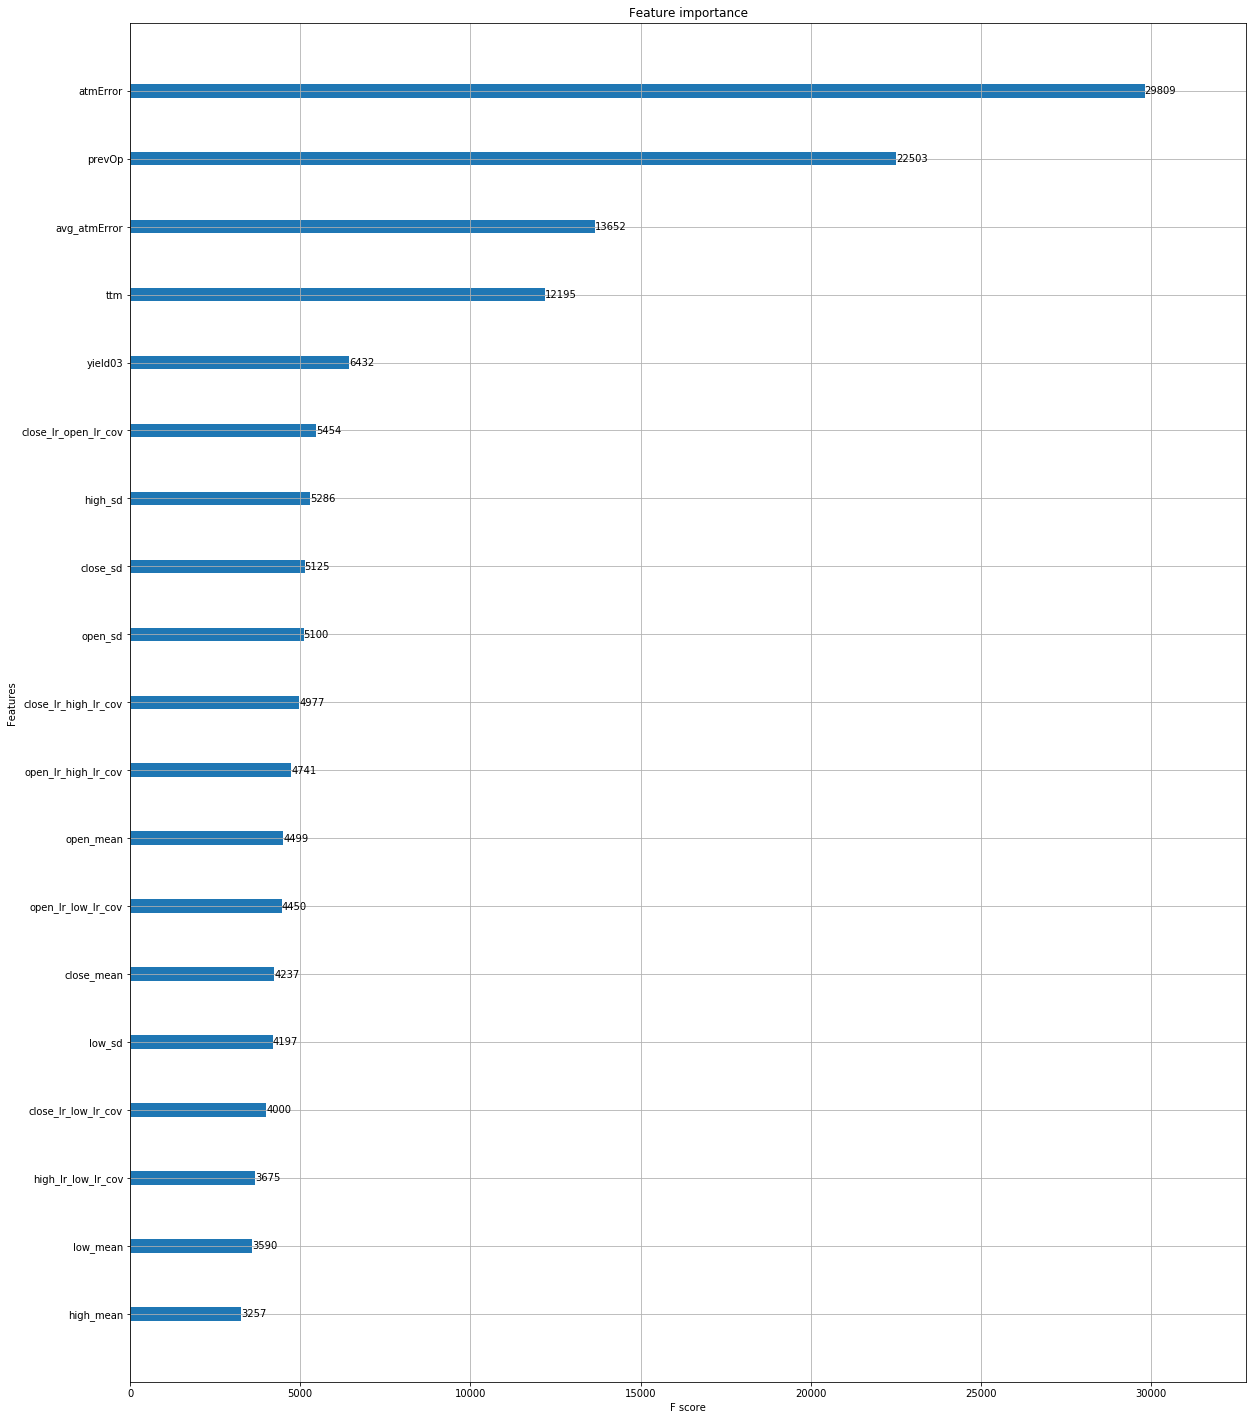

In [12]:
plt.rcParams['figure.figsize'] = [20, 25]
plot_importance(model)
plt.show()

# Testing BNF+NF on NF and BNF separately 

In [14]:
## NF


n_feats = n_feats.sample(frac=1).reset_index(drop=True)

nf_Ytest = n_feats.loc[:, 'Target']
nf_Xtest = n_feats.iloc[:, :-1]

featNames = list(nf_Xtest)

nf_Xtest = scaler.transform(nf_Xtest)
nf_Xtest = pd.DataFrame(nf_Xtest, columns = featNames)


pred = model.predict(nf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - nf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(nf_Ytest))


NEM :: 0.03784403669724771


In [15]:
## BNF


bnf_Ytest = b_feats.loc[:, 'Target']
bnf_Xtest = b_feats.iloc[:, :-1]

featNames = list(bnf_Xtest)

bnf_Xtest = scaler.transform(bnf_Xtest)
bnf_Xtest = pd.DataFrame(bnf_Xtest, columns = featNames)


pred = model.predict(bnf_Xtest)

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - bnf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(bnf_Ytest))


NEM :: 0.044836876653277166
